In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import numpy as np

import statsmodels.api as sm

import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
import platform
if platform.system() == 'Windows':
    basepath = r'C:\Users\jenniferwh\Dropbox (Allen Institute)\Mesoscale Connectome Papers in Progress/2019 DMN'
elif platform.system() == 'Darwin':
    basepath = r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN'
path = os.path.join(basepath, '_new_figures', 'Figure_2')
maskpath = os.path.join(basepath, 'fMRI_masks')

In [3]:
import nrrd
both_dmn_masks, _ = nrrd.read(os.path.join(maskpath, 'dmn_mask_and_core.nrrd'))
dmn_mask = np.zeros(both_dmn_masks.shape)
dmn_mask[np.where(both_dmn_masks > 0)] = 1
core_mask = np.zeros(both_dmn_masks.shape)
core_mask[np.where(both_dmn_masks == 2)] = 1

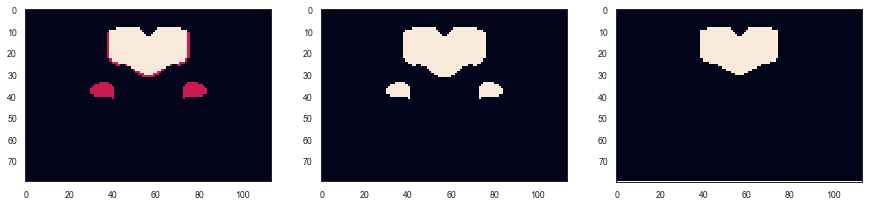

In [4]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].imshow(both_dmn_masks[50])
ax[1].imshow(dmn_mask[50])
ax[2].imshow(core_mask[50])

## Figure 2a

In [5]:
import scipy.ndimage
def get_mask(axis):
    mask, _ = nrrd.read(os.path.join(maskpath, 
                                     'all ICA components and masks zscore 1',
                                     'ica_all_05_icasso_iter_1000_comp_1_mask_z_1_allen_masked_sym_thresh_2.nrrd'))
    mask1 = make_mask(mask, axis)
    return mask1

def get_core_mask(axis):
    mask1 = make_mask(mask, axis)
    return mask1

def make_mask(mask, axis):
    mask = scipy.ndimage.filters.gaussian_filter(mask, 1, order = 0)
    mask = scipy.ndimage.zoom(mask, 4, order=2)
    if axis == 'horizontal':
        mask = mask.max(axis = 1)
    elif axis == 'sagittal':
        mask = mask[:,:,228:]
        mask = mask.max(axis = 2)
    elif axis == 'section':
        mask[np.where(mask < -0.1)] = np.nan
        
    return mask

In [6]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
mcc = MouseConnectivityCache(manifest_file='../connectivity/mouse_connectivity_manifest.json',
                            resolution=25) #Use 25 for images, 100 for calculations
template, _ = mcc.get_template_volume()

In [7]:
ctx_glm_dat = pd.read_csv(os.path.join(basepath, 
                                       'data_files',
                                       'wt_cre_ctx_injections_DMN_and_core_projections_coefficients_inverse.csv'))
ctx_glm_dat['injection dmn fraction'] = [1-fraction for fraction in ctx_glm_dat['injection dmn fraction'].values]
ctx_coord_dat = pd.read_csv(os.path.join(basepath, 
                                         'data_files',
                                         'cortical_flatmap_coordinates.csv'))

In [8]:
structure_tree = mcc.get_structure_tree()
summary_structures = structure_tree.get_structures_by_set_id([167587189])
summary_structure_ids = [item['id'] for item in summary_structures]
print(len(summary_structure_ids))

316


In [9]:
mcc = MouseConnectivityCache(manifest_file='../connectivity/mouse_connectivity_manifest.json',
                            resolution=10)

In [10]:
iso = structure_tree.get_structures_by_acronym(['Isocortex'])[0] # get a 100 um isocortex mask
ctx_exps = pd.DataFrame(mcc.get_experiments(cre=False, 
                                       injection_structure_ids=[iso['id']]))
print(len(ctx_exps))

129


In [11]:
cre_experiments = pd.DataFrame(mcc.get_experiments(cre=['Emx1-IRES-Cre','Rbp4-Cre_KL100'],
                                      injection_structure_ids = [iso['id']]))
ctx_exps = pd.concat([ctx_exps, cre_experiments])

'''fail_expts = [114008926, 120280939, 180073473, 180403712, 180601025, 183174303, 183329222,
              249396394, 296047806, 299446445, 301060890, 303784745, 480069939, 482578964, 
              506947040, 514333422, 525796603, 545428296, 559878074, 638314843, 182888003,
             304585910, 183171679, 272930013, 523718075, 517072832, 148964212, 304762965,
             566992832, 272930013, 304762965, 266250904, 114399224, 286483411, 286417464,
             593277684, 546103149, 642809043, 286483411, 304564721] #VISp outlier excluded

ctx_exps = ctx_exps[~ctx_exps['id'].isin(fail_expts)]
'''
print(len(ctx_exps))

300


In [12]:
ia_map = structure_tree.get_id_acronym_map()
ai_map = {value: key for key, value in ia_map.items()}

In [13]:
ctx_exps = ctx_exps.merge(ctx_glm_dat[['id', 'injection dmn fraction', 
                                       'projection dmn fraction',
                                      'DMN coefficient']], on = 'id',
                         how = 'left')

ctx_exps = ctx_exps.merge(ctx_coord_dat[['id', 
                                         'top_x', 
                                       'top_y']], on = 'id',
                         how = 'left')
ctx_exps['percent_dmn'] = ctx_exps['projection dmn fraction']*100
ctx_exps['injection_percent_dmn'] = ctx_exps['injection dmn fraction']*100
ctx_exps.rename(columns = {'DMN coefficient': 'DMN_coefficient'}, inplace = True)

In [14]:
len(ctx_exps)

300

## Plot wild type cortical injections on top down cortex view

In [15]:
import imageio
imb = imageio.imread(os.path.join(path, 'DMN_cortical_projection_boundaries.png'))
imm = imageio.imread(os.path.join(path, 'CorticalProjectionsSurfaceMapModules.png'))

In [16]:
ctx_exps['percent_dmn'].max()

98.3740636301408

In [17]:
print(ctx_exps['DMN_coefficient'].min())
print(ctx_exps['DMN_coefficient'].max())

-0.3920405971193927
0.5869309856195783


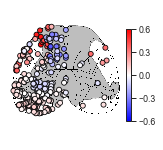

In [18]:
fig,ax = plt.subplots(1,1)
ax.imshow(imb)
ctx_exps['sorter'] = ctx_exps.injection_z.abs()
ctx_exps.sort_values(by='sorter', inplace = True, ascending = False)
cax = ax.scatter(ctx_exps.top_x,
           ctx_exps.top_y,
           c = ctx_exps['DMN_coefficient'],
           edgecolor = 'k',
           s = 25,
           cmap = 'bwr',
                 vmax = 0.6,
                 vmin = -0.6)
# put ORBl, AId, AIv on top
cax = ax.scatter(ctx_exps[ctx_exps['id'].isin(
    [180709230, 166153483, 296048512, 272737914, 112596790,
    521600943, 540145406, 518606617, 657334568, 272929308, 524874308])].top_x, #ORBl, AIv, AId, AId
           ctx_exps[ctx_exps['id'].isin(
    [180709230, 166153483, 296048512, 272737914, 112596790,
    521600943, 540145406, 518606617, 657334568, 272929308, 524874308])].top_y,
           c = ctx_exps[ctx_exps['id'].isin(
    [180709230, 166153483, 296048512, 272737914, 112596790,
    521600943, 540145406, 518606617, 657334568, 272929308, 524874308])]['DMN_coefficient'],
           edgecolor = 'k',
           s = 25,
           cmap = 'bwr',
                 vmax = 0.6,
                 vmin = -0.6,
                zorder = 1)
cbar = plt.colorbar(cax, ax = ax, orientation='vertical', 
                    fraction=0.033, ticks = [-0.6, -0.3, 0, 0.3, 0.6],
                    pad=0.01)

cbar.solids.set_rasterized(True)
cbar.solids.set_edgecolor("face")
cbar.set_alpha(1)
cbar.draw_all()
ax.set_aspect('equal')
plt.axis('off')
fig.set_size_inches(2.5,2.5)
fig_s2_path = r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/Figure_S2'
plt.savefig(os.path.join(fig_s2_path, 'wt_injections_on_DMN_ctx_DMN_coefficient_inverse.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

In [19]:
len([ctx_exps['DMN_coefficient']==0])

1

(-0.5, 1139.5, 1319.5, -0.5)

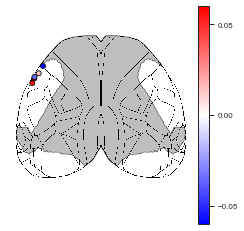

In [20]:
fig,ax = plt.subplots(1,1)
ax.imshow(imb)
cax = ax.scatter(ctx_exps[ctx_exps['id'].isin(
    [180709230, 166153483, 296048512, 272737914, 112596790])].top_x, #ORBl, AIv, AId, AId
           ctx_exps[ctx_exps['id'].isin(
    [180709230, 166153483, 296048512, 272737914, 112596790])].top_y,
           c = ctx_exps[ctx_exps['id'].isin(
    [180709230, 166153483, 296048512, 272737914, 112596790])]['DMN_coefficient'],
           edgecolor = 'k',
           s = 25,
           cmap = 'bwr',
                 vmax = 0.06,
                 vmin = -0.06)

cbar = plt.colorbar(cax, ax = ax, orientation='vertical', 
                    fraction=0.033, ticks = [-0.05, 0, 0.05],
                    pad=0.01)
cbar_ax = fig.axes[-1]
cbar.solids.set_rasterized(True)
cbar.solids.set_edgecolor("face")
cbar.set_alpha(1)
cbar.draw_all()
cbar.ax.tick_params(labelsize=8) 
ax.set_aspect('equal')
plt.axis('off')

(-0.5, 1139.5, 1319.5, -0.5)

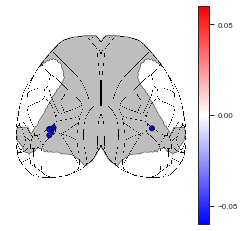

In [21]:
fig,ax = plt.subplots(1,1)
ax.imshow(imb)
cax = ax.scatter(ctx_exps[ctx_exps['id'].isin(
    [521600943, 540145406, 518606617, 657334568, 272929308, 524874308])].top_x, #VISrl
           ctx_exps[ctx_exps['id'].isin(
    [521600943, 540145406, 518606617, 657334568, 272929308, 524874308])].top_y,
           c = ctx_exps[ctx_exps['id'].isin(
    [521600943, 540145406, 518606617, 657334568, 272929308, 524874308])]['DMN_coefficient'],
           edgecolor = 'k',
           s = 25,
           cmap = 'bwr',
                 vmax = 0.06,
                 vmin = -0.06)

cbar = plt.colorbar(cax, ax = ax, orientation='vertical', 
                    fraction=0.033, ticks = [-0.05, 0, 0.05],
                    pad=0.01)
cbar_ax = fig.axes[-1]
cbar.solids.set_rasterized(True)
cbar.solids.set_edgecolor("face")
cbar.set_alpha(1)
cbar.draw_all()
cbar.ax.tick_params(labelsize=8) 
ax.set_aspect('equal')
plt.axis('off')

In [22]:
ctx_exps[ctx_exps['structure_abbrev'] == 'VISrl']['DMN_coefficient']

224   -0.068051
220   -0.117226
266   -0.075409
175   -0.105683
145   -0.098807
197   -0.075735
Name: DMN_coefficient, dtype: float64

In [23]:
ctx_exps.loc[ctx_exps['structure_abbrev'].isin(['ACAd', 'ACAv', 'ORBl','ORBm', 'ORBvl', 
                                                'ILA', 'PL', 'FRP']), 'module'] = 'Prefrontal'
ctx_exps.loc[ctx_exps['structure_abbrev'].isin(['VISam', 'RSPagl', 'RSPv', 'VISpm',
                                                'VISa', 'RSPd']), 'module'] = 'Medial'
ctx_exps.loc[ctx_exps['structure_abbrev'].isin(['SSp-tr', 'SSp-ll', 'SSp-bfd', 'SSp-un',
                                                'SSp-ul', 'MOs', 'MOp', 'SSs', 'SSp-n',
                                                'SSp-m']), 'module'] = 'Somatomotor'
ctx_exps.loc[ctx_exps['structure_abbrev'].isin(['VISal', 'VISl', 'VISli', 'VISp', 'VISpl',
                                                'VISpor', 'VISrl']), 'module'] = 'Visual'
ctx_exps.loc[ctx_exps['structure_abbrev'].isin(['AUDpo', 'AUDd', 'AUDp', 'AUDv']), 
                'module'] = 'Auditory'
ctx_exps.loc[ctx_exps['structure_abbrev'].isin(['TEa', 'PERI', 'ECT', 'GU', 'AId', 'AIv',
                                                'AIp', 'VISC']), 'module'] = 'Lateral'
print(len(ctx_exps[ctx_exps['module'].isnull()]))

0


In [24]:
module_colors = {'Prefrontal': '#ff0000', 'Medial': '#5252a9', 'Somatomotor': '#f9922b', 
                 'Lateral': '#ffff66', 'Visual': '#90bff9', 'Auditory': '#7c429b'}

## DMN coefficient graphs (for reviewer)

In [25]:
S2path = r'/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/Figure_S2'

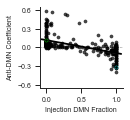

In [29]:
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.regplot(x = 'injection dmn fraction',
            y = 'DMN coefficient',
            data = ctx_glm_dat,
            ax = ax,
            color = 'k',
            ci=False,
            scatter_kws={'alpha':0.7, 'linewidth': 0.5,
                         'edgecolor': 'k', 's':10,
                        'zorder':1})
sns.regplot(x = 'injection dmn fraction',
            y = 'DMN coefficient',
            data = ctx_glm_dat[ctx_glm_dat['id'] == 125833030],
            ax = ax,
            color = 'k',
            ci=False,
            fit_reg = False,
            scatter_kws={'alpha':0.7, 'linewidth': 0.5,
                         'edgecolor': '#00ffff', 's':10,
                        'zorder':10})
sns.regplot(x = 'injection dmn fraction',
            y = 'DMN coefficient',
            data = ctx_glm_dat[ctx_glm_dat['id'] == 180436360],
            ax = ax,
            color = 'k',
            ci=False,
            fit_reg = False,
            scatter_kws={'alpha':0.7, 'linewidth': 0.5,
                         'edgecolor': 'lime', 's':10,
                        'zorder':10})
ax.set_xlim([-0.1, 1.1])
ax.set_xlabel('Injection DMN Fraction', fontsize = 7)
ax.set_ylim([-0.65, 0.65])
ax.set_ylabel('Anti-DMN Coefficient', fontsize = 7)
plt.xticks([0, 0.5, 1], fontsize = 7)
plt.yticks([-0.6, -0.3, 0, 0.3, 0.6], fontsize = 7)
ax.tick_params(top = False, right = False, left = True, bottom=True)
plt.axhline(y=0, linestyle='--', linewidth=0.5, zorder=-1, color = 'gray')
sns.despine()
#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)

plt.savefig(os.path.join(S2path, 'wt_DMN_coeff_inverse.pdf'), 
            bbox_inches='tight', transparent=True, dpi=300)

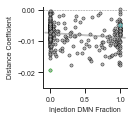

In [35]:
ctx_glm_dat['distance_coeff_x10'] = 10*ctx_glm_dat['distance coefficient']
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.regplot(x = 'injection dmn fraction',
            y = 'distance coefficient',
            data = ctx_glm_dat,
            ax = ax,
            ci = False,
            color = 'darkgray',
            scatter_kws={'s':10, 'linewidth':0.5, 
                      'edgecolor': 'k',
                        'zorder':-1},
            line_kws={'zorder': -2, 'alpha':0.8},
           label = r'Distance (r=-0.16)')
sns.regplot(x = 'injection dmn fraction',
            y = 'distance coefficient',
            data = ctx_glm_dat[ctx_glm_dat['id'] == 125833030],
            ax = ax,
            color = 'darkgray',
            ci=False,
            fit_reg = False,
            scatter_kws={'alpha':0.7, 'linewidth': 0.5,
                         'edgecolor': '#00ffff', 's':10,
                        'zorder':10})
sns.regplot(x = 'injection dmn fraction',
            y = 'distance coefficient',
            data = ctx_glm_dat[ctx_glm_dat['id'] == 180436360],
            ax = ax,
            color = 'darkgray',
            ci=False,
            fit_reg = False,
            scatter_kws={'alpha':0.7, 'linewidth': 0.5,
                         'edgecolor': 'lime', 's':10,
                        'zorder':10})
ax.set_xlim([-0.1, 1.1])
ax.set_xlabel('Injection DMN Fraction', fontsize = 7)
ax.set_ylim([-0.025, 0.001])
ax.tick_params(top = False, right = False, left = True, bottom=True)
ax.set_ylabel('Distance Coefficient', fontsize = 7)
plt.yticks([-0.02, -0.01, 0], fontsize = 7)
plt.xticks([0, 0.5, 1], fontsize = 7)
plt.axhline(y=0, linestyle='--', linewidth=0.5, zorder=-1, color = 'gray')
sns.despine()

plt.savefig(os.path.join(S2path, 'wt_distance_coeff_inverse.pdf'), 
            bbox_inches='tight', transparent=True, dpi=300)

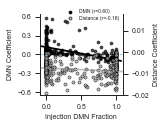

In [49]:
ctx_glm_dat['distance_coeff_x10'] = 10*ctx_glm_dat['distance coefficient']
fig, ax = plt.subplots(figsize = (1.5, 1.5))
sns.regplot(x = 'injection dmn fraction',
            y = 'DMN coefficient',
            data = ctx_glm_dat,
            ax = ax,
            color = 'k',
            ci=False,
            scatter_kws={'alpha':0.7, 'linewidth': 0.5,
                         'edgecolor': 'k', 's':10,
                        'zorder':1},
           label = r'DMN (r=0.60)')
'''
sns.regplot(x = 'inj_percent_core',
            y = 'DMN core coefficient',
            data = ctx_glm_dat,
            ax = ax,
            color = 'k',
            scatter_kws={'alpha':0.7, 's':10},
           label = r'Core (r=)')
           '''
ax.set_xlim([-0.1, 1.1])
ax.set_xlabel('Injection DMN Fraction', fontsize = 7)
ax.set_ylim([-0.65, 0.65])
ax.set_ylabel('DMN Coefficient', fontsize = 7)
plt.xticks([0, 0.5, 1], fontsize = 7)
plt.yticks([-0.6, -0.3, 0, 0.3, 0.6], fontsize = 7)
ax.tick_params(top = False, right = False, left = True, bottom=True)
plt.axhline(y=0, linestyle='--', linewidth=0.5, zorder=-1)

leg = plt.legend(fontsize = 5, labelspacing=0.2, frameon = False,
          loc = 1, bbox_to_anchor = [0.89, 1.11])
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# Plot distance coefficient on right axis
ax2 = ax.twinx()
sns.regplot(x = 'injection dmn fraction',
            y = 'distance coefficient',
            data = ctx_glm_dat,
            ax = ax2,
            ci = False,
            color = 'darkgray',
            scatter_kws={'s':10, 'linewidth':0.5, 
                      'edgecolor': 'k',
                        'zorder':-1},
            line_kws={'zorder': -2, 'alpha':0.8},
           label = r'Distance (r=-0.16)')
ax2.set_ylim([-0.02, 0.018])
ax2.tick_params(top = False, right = True, left = False, bottom=True)
ax2.set_ylabel('Distance Coefficient', fontsize = 7)
plt.yticks([-0.02, -0.01, 0, 0.01], fontsize = 7)
sns.despine(right = False)

leg = plt.legend(fontsize = 5, labelspacing=0.2, frameon = False,
          loc = 1, bbox_to_anchor = [1, 1.03])
for lh in leg.legendHandles: 
    lh.set_alpha(1)

#everything on zorder -1 or lower will be rasterized
ax.set_rasterization_zorder(0)

plt.savefig(os.path.join(S2path, 'wt_distance_DMN_coeff_inverse.pdf'), bbox_inches='tight', transparent=True, dpi=300)

In [50]:
print(ctx_glm_dat['distance coefficient'].min())
print(ctx_glm_dat['distance coefficient'].max())

-0.0192118216326992
0.00011174013386437698


In [51]:
10**-4

0.0001

In [52]:
x=ctx_glm_dat['injection dmn fraction']
y = ctx_glm_dat['distance coefficient']
fit = sm.OLS(y, sm.add_constant(x, prepend=True)).fit()
print(fit.summary())

                             OLS Regression Results                             
Dep. Variable:     distance coefficient   R-squared:                       0.027
Model:                              OLS   Adj. R-squared:                  0.023
Method:                   Least Squares   F-statistic:                     8.189
Date:                  Thu, 06 Aug 2020   Prob (F-statistic):            0.00451
Time:                          23:10:21   Log-Likelihood:                 1250.4
No. Observations:                   300   AIC:                            -2497.
Df Residuals:                       298   BIC:                            -2489.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const   

/Users/jenniferwh/Dropbox (Allen Institute)/Mesoscale Connectome Papers in Progress/2019 DMN/_new_figures/jupyter_notebooks/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [53]:
scipy.stats.pearsonr(y, x)

(-0.16354261361358677, 0.004511905351785778)

In [54]:
x=ctx_glm_dat['injection dmn fraction']
y = ctx_glm_dat['DMN coefficient']
fit = sm.OLS(y, sm.add_constant(x, prepend=True)).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:        DMN coefficient   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     165.1
Date:                Thu, 06 Aug 2020   Prob (F-statistic):           2.29e-30
Time:                        23:10:44   Log-Likelihood:                 214.63
No. Observations:                 300   AIC:                            -425.3
Df Residuals:                     298   BIC:                            -417.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [55]:
scipy.stats.pearsonr(y, x)

(-0.5970670608354814, 2.294573110821451e-30)

In [57]:
in_strs = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'VISa', 'VISam', 'RSPagl',
    'RSPd', 'RSPv', 'SSp-tr', 'SSp-ll', 'MOs']
ctx_glm_dat.loc[ctx_glm_dat['injection structure'].isin(in_strs), 'in-out'] = 'in'
ctx_glm_dat.loc[~ctx_glm_dat['injection structure'].isin(in_strs), 'in-out'] = 'out'

In [61]:
# Custom order
plot_order = ['ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'VISa', 'VISam', 
              'RSPagl', 'RSPd', 'RSPv', 'SSp-tr', 'SSp-ll', 'MOs',
              'SSs', 'SSp-bfd', 'SSp-ul', 'SSp-un', 'SSp-n', 'SSp-m', 'MOp',
              'FRP', 'VISpm', 'AId', 'AIv', 'AIp', 'GU', 'VISC', 'ECT', 'VISal', 'VISl', 
              'VISp', 'VISpl', 'VISli', 'VISpor', 'VISrl', 'AUDd', 'AUDp', 'AUDpo', 'AUDv']
print([structure for structure in ctx_glm_dat['injection structure'].unique() 
       if structure not in plot_order])
print([structure for structure in plot_order
       if structure not in ctx_glm_dat['injection structure'].unique() ])

[]
[]


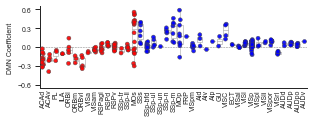

In [63]:
fig, ax = plt.subplots(1, figsize = (4.8, 1.5))
sns.boxplot('injection structure', 'DMN coefficient', 
            data = ctx_glm_dat[ctx_glm_dat['in-out'] == 'out'], 
            order = plot_order, ax = ax, color = 'white',
            linewidth = 0.5,
           fliersize = 0.1)
sns.stripplot('injection structure', 'DMN coefficient', 
              data = ctx_glm_dat[ctx_glm_dat['in-out'] == 'out'], 
            order = plot_order, ax = ax, linewidth = 0.5,
              color = 'b', s = 4, alpha = 0.9)
sns.boxplot('injection structure', 'DMN coefficient', 
            data = ctx_glm_dat[ctx_glm_dat['in-out'] == 'in'], 
            order = plot_order, ax = ax, color = 'white',
           linewidth = 0.5, fliersize = 1)
sns.stripplot('injection structure', 'DMN coefficient', 
              data = ctx_glm_dat[ctx_glm_dat['in-out'] == 'in'], 
            order = plot_order, ax = ax, linewidth = 0.5,
             color = 'r', s = 4, alpha = 0.9)
ax.set_xticks(np.linspace(ax.get_xbound()[0]+0.5, 
                          ax.get_xbound()[1]-0.5, len(plot_order)))
plt.xticks(rotation = 90, fontsize = 7)
plt.yticks(fontsize = 7)
sns.despine()
ax.tick_params(top = False, right = False, left = True)
ax.set_xlabel("")
ax.set_ylabel("DMN Coefficient", fontsize = 7)
ax.tick_params(top = False, right = False)
ax.tick_params('x', pad=-3)
ax.set_ylim([-0.65, 0.65])
ax.set_yticks([-0.6, -0.3, 0, 0.3, 0.6])
ax.axhline(y = 0, xmin=0, xmax=1, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
plt.savefig(os.path.join(S2path, 'DMN_coeff_by_source_wt_boxplot_in-out_inverse.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)

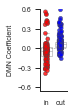

In [64]:
fig, ax = plt.subplots(1, figsize = (0.5, 1.5))
sns.boxplot('in-out', 'DMN coefficient',  
            data = ctx_glm_dat, ax = ax, color = 'white', order = ['in', 'out'],
           linewidth = 0.5, fliersize = 0.1)
sns.stripplot('in-out', 'DMN coefficient',
              data = ctx_glm_dat, order = ['in', 'out'], linewidth = 0.5,
              ax = ax, palette = ['r', 'b'], s = 4, alpha = 0.8)
ax.set_ylim([-0.65, 0.6])
ax.set_yticks([-0.6, -0.3, 0, 0.3, 0.6])
plt.yticks(fontsize = 7)
plt.xticks([0, 1], fontsize = 7)
sns.despine()
ax.tick_params(top = False, right = False)
ax.set_xlabel("")
ax.set_ylabel("DMN Coefficient", fontsize = 7)
ax.tick_params(top = False, right = False, left = True)
ax.axhline(y = 0, xmin=0, xmax=100, color = 'gray', linestyle = 'dashed',
          linewidth = 0.5)
plt.savefig(os.path.join(S2path, 'DMN_coeff_wt_boxplot_in-out_inverse.pdf'), 
            bbox_inches='tight', pad_inches=0.3, format='pdf', transparent=True, dpi=300)